# Visual-language assistant with Qwen2VL and OpenVINO

Qwen2VL is the latest addition to the QwenVL series of multimodal large language models.

**Key Enhancements of Qwen2VL:**
* **SoTA understanding of images of various resolution & ratio**: Qwen2-VL achieves state-of-the-art performance on visual understanding benchmarks, including MathVista, DocVQA, RealWorldQA, MTVQA, etc.
* **Understanding videos of 20min+**: Qwen2-VL can understand videos over 20 minutes for high-quality video-based question answering, dialog, content creation, etc.
* **Agent that can operate your mobiles, robots, etc.:** with the abilities of complex reasoning and decision making, Qwen2-VL can be integrated with devices like mobile phones, robots, etc., for automatic operation based on visual environment and text instructions.
* **Multilingual Support:** to serve global users, besides English and Chinese, Qwen2-VL now supports the understanding of texts in different languages inside images, including most European languages, Japanese, Korean, Arabic, Vietnamese, etc.


**Model Architecture Details:**

* **Naive Dynamic Resolution**: Qwen2-VL can handle arbitrary image resolutions, mapping them into a dynamic number of visual tokens, offering a more human-like visual processing experience.

<p align="center">
    <img src="https://qianwen-res.oss-accelerate-overseas.aliyuncs.com/Qwen2-VL/qwen2_vl.jpg" width="50%"/>
<p>

* **Multimodal Rotary Position Embedding (M-ROPE)**: Decomposes positional embedding into parts to capture 1D textual, 2D visual, and 3D video positional information, enhancing its multimodal processing capabilities.

<p align="center">
    <img src="http://qianwen-res.oss-accelerate-overseas.aliyuncs.com/Qwen2-VL/mrope.png" width="50%"/>
<p>



More details about model can be found in [model card](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct), [blog](https://qwenlm.github.io/blog/qwen2-vl/) and original [repo](https://github.com/QwenLM/Qwen2-VL).

In this tutorial we consider how to convert and optimize Qwen2VL model for creating multimodal chatbot. Additionally, we demonstrate how to apply stateful transformation on LLM part and model optimization techniques like weights compression using [NNCF](https://github.com/openvinotoolkit/nncf)
#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Select model](#Select-model)
- [Convert and Optimize model](#Convert-and-Optimize-model)
    - [Compress model weights to 4-bit](#Compress-model-weights-to-4-bit)
- [Prepare model inference pipeline](#Prepare-model-inference-pipeline)
    - [Select inference device](#Select-inference-device)
- [Run model inference](#Run-model-inference)
- [Interactive Demo](#Interactive-Demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/qwen2-vl/qwen2-vl.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
%pip install -q "transformers>=4.45" "torch>=2.1" "torchvision" "qwen-vl-utils" "Pillow" "gradio>=4.36" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -qU "openvino>=2024.4.0" "nncf>=2.13.0"

In [2]:
from pathlib import Path
import requests

if not Path("ov_qwen2_vl.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/qwen2-vl/ov_qwen2_vl.py")
    open("ov_qwen2_vl.py", "w").write(r.text)

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w").write(r.text)

## Select model
[back to top ⬆️](#Table-of-contents:)

There are multiple Qwen2VL models available in [models collection](https://huggingface.co/collections/OpenGVLab/internvl-20-667d3961ab5eb12c7ed1463e). You can select one of them for conversion and optimization in notebook using widget bellow:

In [3]:
from ov_qwen2_vl import model_selector

model_id = model_selector()

model_id

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


2024-09-11 11:23:32.122183: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-11 11:23:32.123963: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-11 11:23:32.162285: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-11 11:23:32.850649: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Dropdown(description='Model:', options=('Qwen/Qwen2-VL-2B-Instruct', 'Qwen/Qwen2-VL-7B-Instruct'), value='Qwen…

In [4]:
print(f"Selected {model_id.value}")
pt_model_id = model_id.value
model_dir = Path(pt_model_id.split("/")[-1])

Selected Qwen/Qwen2-VL-2B-Instruct


## Convert and Optimize model
[back to top ⬆️](#Table-of-contents:)

Qwen2VL is PyTorch model. OpenVINO supports PyTorch models via conversion to OpenVINO Intermediate Representation (IR). [OpenVINO model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html#convert-a-model-with-python-convert-model) should be used for these purposes. `ov.convert_model` function accepts original PyTorch model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. Converted model can be used for saving on disk using `ov.save_model` function or directly loading on device using `core.compile_model`. 
`ov_qwen2_vl.py` script contains helper function for model conversion, please check its content if you interested in conversion details.

<details>
  <summary><b>Click here for more detailed explanation of conversion steps</b></summary>
Qwen2VL is autoregressive transformer generative model, it means that each next model step depends from model output from previous step. The generation approach is based on the assumption that the probability distribution of a word sequence can be decomposed into the product of conditional next word distributions. In other words, model predicts the next token in the loop guided by previously generated tokens until the stop-condition will be not reached (generated sequence of maximum length or end of string token obtained). The way the next token will be selected over predicted probabilities is driven by the selected decoding methodology. You can find more information about the most popular decoding methods in this <a href="https://huggingface.co/blog/how-to-generate">blog</a>. The entry point for the generation process for models from the Hugging Face Transformers library is the `generate` method. You can find more information about its parameters and configuration in the  <a href="https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/text_generation#transformers.GenerationMixin.generate">documentation</a>. To preserve flexibility in the selection decoding methodology, we will convert only model inference for one step.

The inference flow has difference on first step and for the next. On the first step, model accept preprocessed input instruction and image, that transformed to the unified embedding space using `input_embedding` and `image_encoder` models, after that `language model`, LLM-based part of model, runs on input embeddings to predict probability of next generated tokens. On the next step, `language_model` accepts only next token id selected based on sampling strategy and processed by `input_embedding` model and cached attention key and values.  Since the output side is auto-regressive, an output token hidden state remains the same once computed for every further generation step. Therefore, recomputing it every time you want to generate a new token seems wasteful. With the cache, the model saves the hidden state once it has been computed. The model only computes the one for the most recently generated output token at each time step, re-using the saved ones for hidden tokens. This reduces the generation complexity from $O(n^3)$ to $O(n^2)$ for a transformer model. More details about how it works can be found in this [article](https://scale.com/blog/pytorch-improvements#Text%20Translation).
To sum up above, model consists of 4 parts:

* **Image encoder** for encoding input images into embedding space.
* **Input Embedding** for conversion input text tokens into embedding space
* **Language Model** for generation answer based on input embeddings provided by Image Encoder and Input Embedding models.

</details>


### Compress model weights to 4-bit
[back to top ⬆️](#Table-of-contents:)
For reducing memory consumption, weights compression optimization can be applied using [NNCF](https://github.com/openvinotoolkit/nncf). 

<details>
    <summary><b>Click here for more details about weight compression</b></summary>
Weight compression aims to reduce the memory footprint of a model. It can also lead to significant performance improvement for large memory-bound models, such as Large Language Models (LLMs). LLMs and other models, which require extensive memory to store the weights during inference, can benefit from weight compression in the following ways:

* enabling the inference of exceptionally large models that cannot be accommodated in the memory of the device;

* improving the inference performance of the models by reducing the latency of the memory access when computing the operations with weights, for example, Linear layers.

[Neural Network Compression Framework (NNCF)](https://github.com/openvinotoolkit/nncf) provides 4-bit / 8-bit mixed weight quantization as a compression method primarily designed to optimize LLMs. The main difference between weights compression and full model quantization (post-training quantization) is that activations remain floating-point in the case of weights compression which leads to a better accuracy. Weight compression for LLMs provides a solid inference performance improvement which is on par with the performance of the full model quantization. In addition, weight compression is data-free and does not require a calibration dataset, making it easy to use.

`nncf.compress_weights` function can be used for performing weights compression. The function accepts an OpenVINO model and other compression parameters. Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

More details about weights compression, can be found in [OpenVINO documentation](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html).
</details>

In [5]:
from ov_qwen2_vl import convert_qwen2vl_model

# uncomment these lines to see model conversion code
# convert_qwen2vl_model??

In [6]:
import nncf

compression_configuration = {
    "mode": nncf.CompressWeightsMode.INT4_ASYM,
    "group_size": 128,
    "ratio": 1.0,
}

convert_qwen2vl_model(pt_model_id, model_dir, compression_configuration)

✅ Qwen/Qwen2-VL-2B-Instruct model already converted. You can find results in Qwen2-VL-2B-Instruct


## Prepare model inference pipeline
[back to top ⬆️](#Table-of-contents:)

As discussed, the model comprises Image Encoder and LLM (with separated text embedding part) that generates answer. In `ov_qwen2_vl.py` we defined inference class `OVQwen2VLModel` that will represent generation cycle, It is based on [HuggingFace Transformers `GenerationMixin`](https://huggingface.co/docs/transformers/main_classes/text_generation) and looks similar to [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) `OVModelForCausalLM` that is used for LLM inference. 

In [7]:
from ov_qwen2_vl import OVQwen2VLModel

# Uncomment below lines to see the model inference class code
# OVQwen2VLModel??

### Select inference device
[back to top ⬆️](#Table-of-contents:)

In [8]:
from notebook_utils import device_widget

device = device_widget(default="AUTO", exclude=["NPU"])

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [9]:
model = OVQwen2VLModel(model_dir, device.value)

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}


## Run model inference
[back to top ⬆️](#Table-of-contents:)

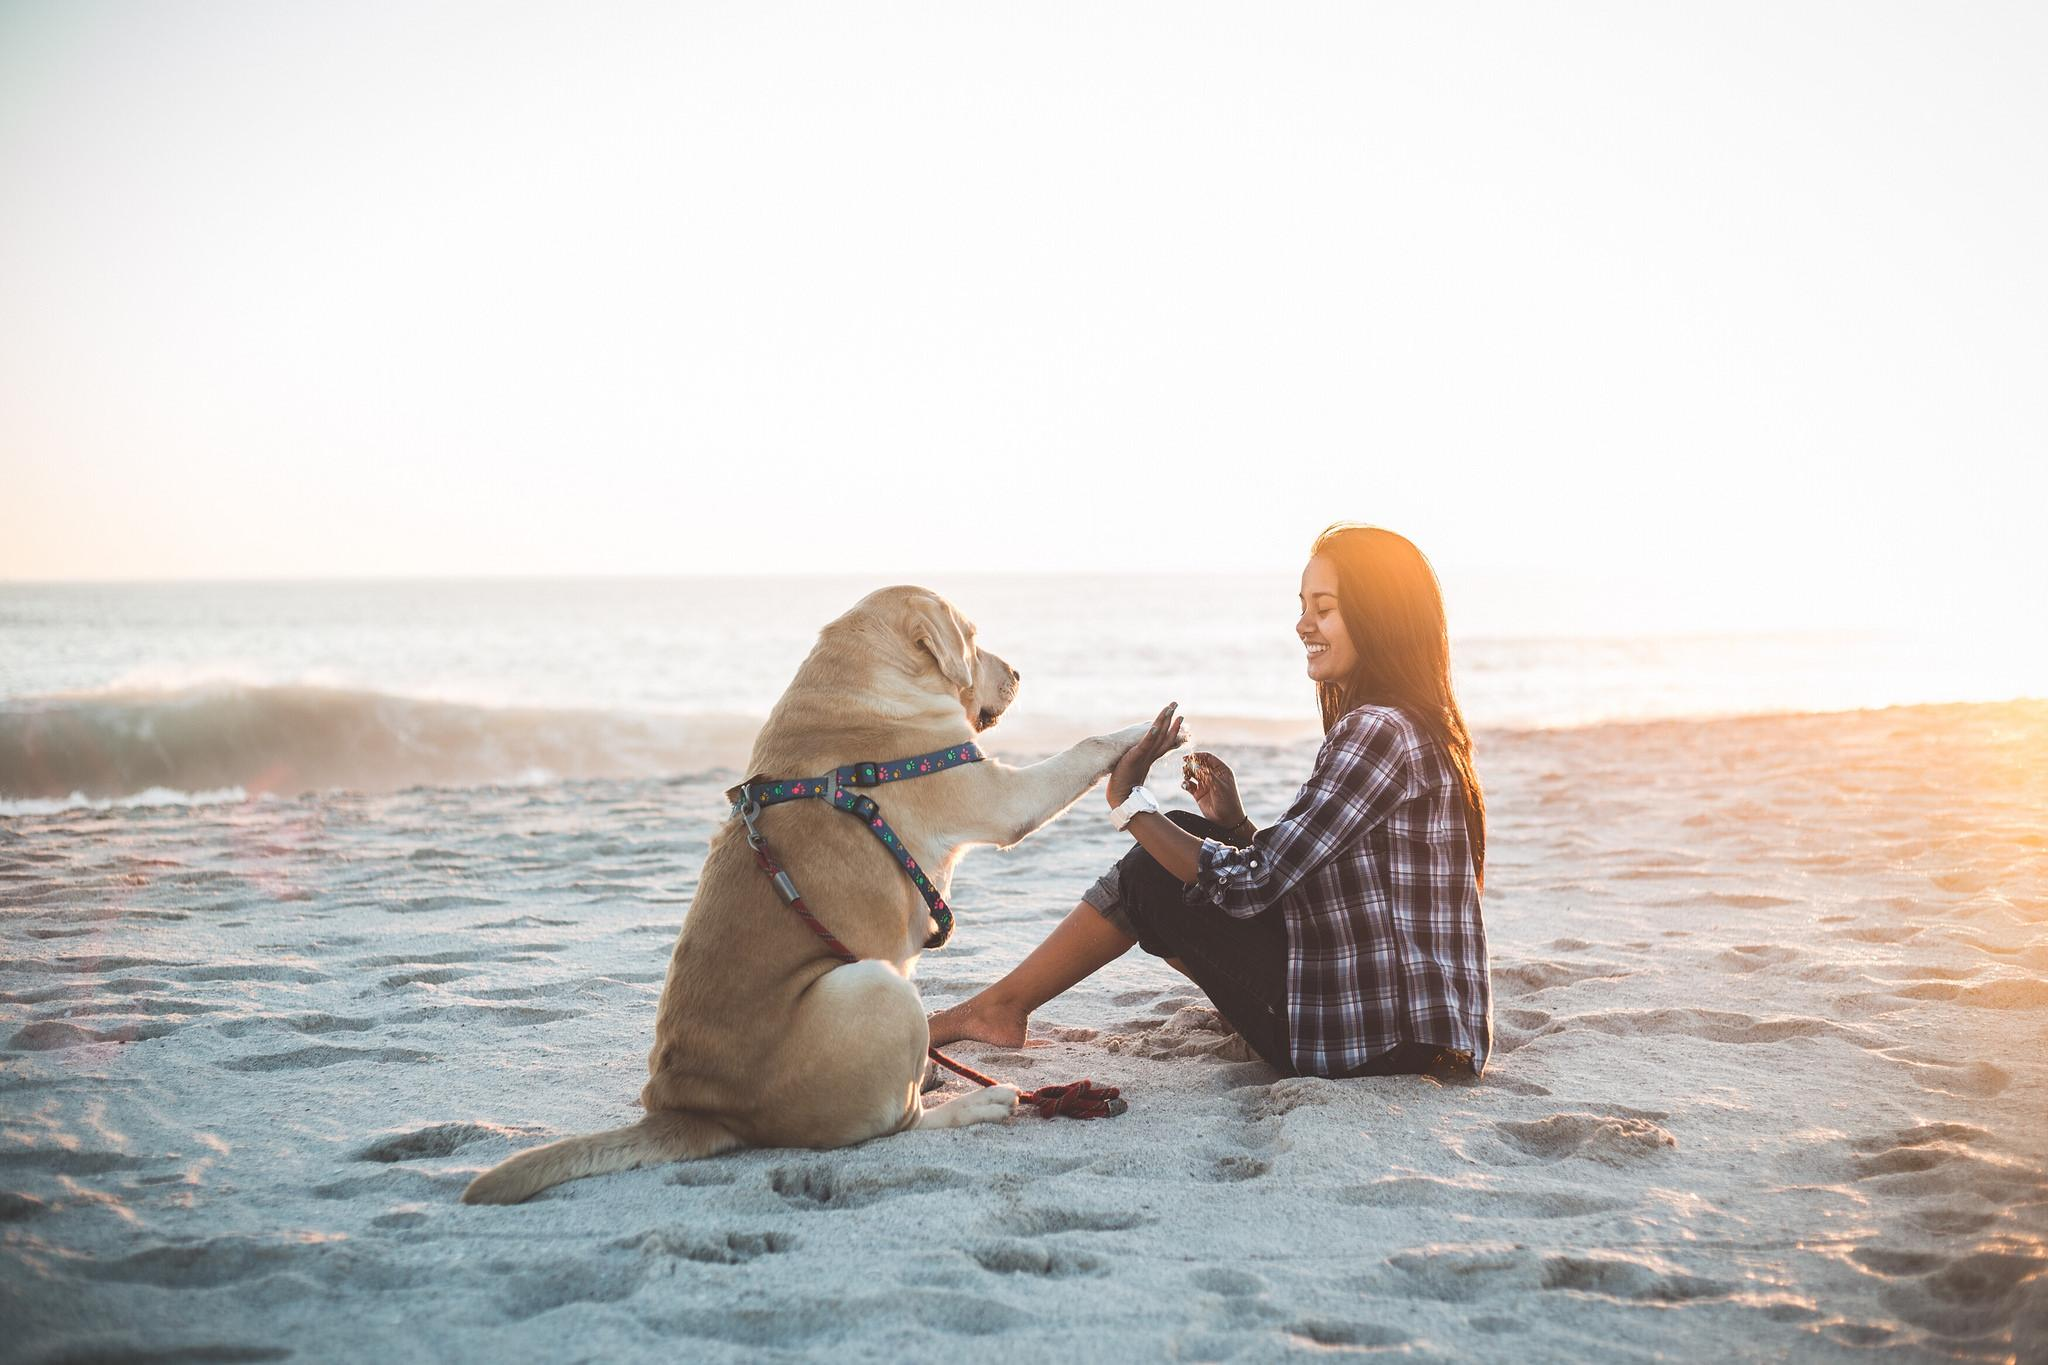

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Question:
Describe this image.
Answer:
The image depicts a woman sitting on a sandy beach with a large dog. The dog is standing on its hind legs, reaching up to give the woman a high-five. The woman is smiling and appears to be enjoying the moment. The background shows the ocean with gentle waves, and the sky is clear with a soft light, suggesting it might be either sunrise or sunset. The scene is serene and joyful, capturing a heartwarming interaction between the woman and her dog.


In [10]:
from PIL import Image
from transformers import AutoProcessor, AutoTokenizer
from qwen_vl_utils import process_vision_info
from transformers import TextStreamer


min_pixels = 256 * 28 * 28
max_pixels = 1280 * 28 * 28
processor = AutoProcessor.from_pretrained(model_dir, min_pixels=min_pixels, max_pixels=max_pixels)

if processor.chat_template is None:
    tok = AutoTokenizer.from_pretrained(model_dir)
    processor.chat_template = tok.chat_template

example_image_url = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"
example_image_path = Path("demo.jpeg")

if not example_image_path.exists():
    Image.open(requests.get(example_image_url, stream=True).raw).save(example_image_path)

image = Image.open(example_image_path)
question = "Describe this image."

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": f"file://{example_image_path}",
            },
            {"type": "text", "text": question},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)

display(image)
print("Question:")
print(question)
print("Answer:")

generated_ids = model.generate(**inputs, max_new_tokens=100, streamer=TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True))

In [11]:
if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/qwen2-vl/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

## Interactive Demo
[back to top ⬆️](#Table-of-contents:)

Now, you can try to chat with model. Upload image or video using `Upload` button, provide your text message into `Input` field and click `Submit` to start communication.

In [13]:
from gradio_helper import make_demo


demo = make_demo(model, processor)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/